In [18]:
import pandas as pd
df = pd.read_csv("../data/creditcard.csv")
df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [19]:
#Counts of each class
print(df["Class"].value_counts())

# Percentage of fraud transactions
fraud_percentage = df["Class"].mean() * 100
print(f"Fraud Percentage: {fraud_percentage:.4f}%")


Class
0    284315
1       492
Name: count, dtype: int64
Fraud Percentage: 0.1727%


In [20]:
from sklearn.model_selection import train_test_split

# Features and target
X = df.drop("Class", axis=1)
y = df["Class"]

# Stratified split to preserve class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training size:", X_train.shape)
print("Test size:", X_test.shape)


Training size: (227845, 30)
Test size: (56962, 30)


Before SMOTE: Class
0    227451
1       394
Name: count, dtype: int64
After SMOTE: Class
0    227451
1    227451
Name: count, dtype: int64
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962

ROC-AUC: 0.9708434302252134


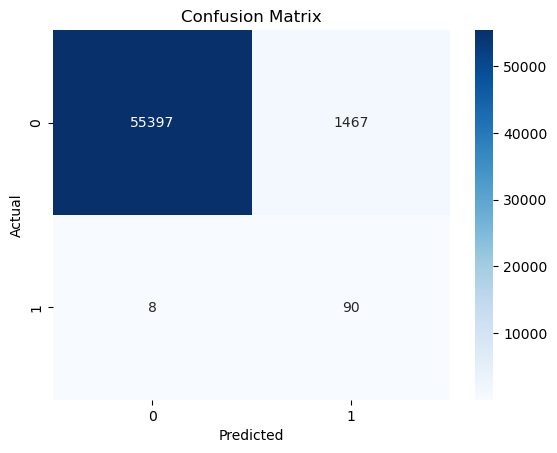

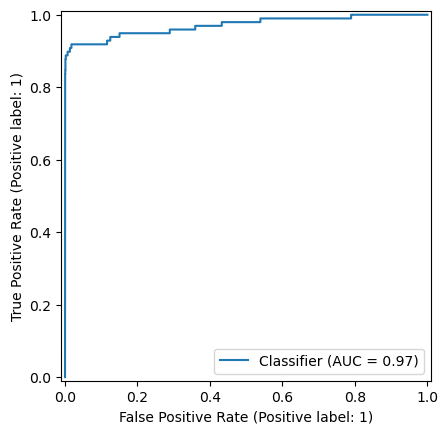

In [21]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE on training set
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_res.value_counts())

# Train Logistic Regression on resampled data
model = LogisticRegression(max_iter=5000)
model.fit(X_train_res, y_train_res)

# Prediction model
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:,1]

# Evaluation
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC curve
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.show()
